# Análisis exploratorio de los datos preliminares de GoFoundMe

En este cuaderno se muestra la exploración de datos que fueron obtenidos mediante *web scrapping* de GoFoundMe.

Primero, importamos las bibliotecas que usaremos:

In [93]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

y cargamos los datos que se van a analizar:

In [120]:
df = pd.read_pickle('../datos/GoFundMeData_VenezuelaCovid_20210421.pkl').explode('tags')
df #echamos un primer vistazo

,url,title,tags,current amount,total_amount,description,created,launch_date,country,donation_count,is_charity
0,https://www.gofundme.com/f/help-otsmars-parent...,Help Otsmar's parents beat Covid-19,"Medical, Illness & Healing","$17,550","$50,000",Sara Schlesinger is organizing this fundraiser...,"Created April 2, 2021",2021-04-02,US,174,false
1,https://www.gofundme.com/f/ecuador-covid19-foo...,Ecuador & Venezuela COVID-19 Food Relief,Volunteer & Service,"$5,730","$6,000",Team fundraiserKirsten Chaplin and 3 others ar...,"Created April 13, 2020",2020-04-13,US,148,false
2,https://www.gofundme.com/f/support-venezuelas-...,Support the Venezuelan COVID-19 Crisis,"Medical, Illness & Healing","$5,350","$5,000",Team fundraiserAlessandra Feuerberg and 2 othe...,"Created April 25, 2020",2020-04-25,US,142,false
3,https://www.gofundme.com/f/pccwcc-williams-med...,Williams' Medical Expenses,"Medical, Illness & Healing","$3,239","$8,000",Team fundraiserRoselyn Vasquez and Jennifer Kn...,"Created April 6, 2021",2021-04-06,US,37,false
4,https://www.gofundme.com/f/help-animals-withou...,Help homeless animals in Venezuela COVID-19,Animals & Pets,"€1,050","€1,800",Christian Vielma is organizing this fundraiser...,"Created July 5, 2020",2020-07-05,US,32,false
...,...,...,...,...,...,...,...,...,...,...,...
995,https://www.gofundme.com/f/maria-eleonor-vielm...,EL MARATÓN DE LA REINA DE NUESTRO CUENTO: MAMÁ...,"Medical, Illness & Healing",£174,"£10,000",Andre Lopez is organizing this fundraiser.EL M...,"Created June 7, 2020",2020-06-07,US,15,false
996,https://www.gofundme.com/f/uncle-luis-wants-to...,Uncle Luis Wants to Live -El Tío Luis Quiere V...,"Medical, Illness & Healing","$1,662","$8,000",Eglee Suarez is organizing this fundraiser.El ...,"Created September 5, 2020",2020-09-05,US,17,false
997,https://www.gofundme.com/f/un-aporte-para-el-d...,Un aporte para el Dr. Daniel Gomez,"Medical, Illness & Healing",€450,"€1,250",Annie Mailin García Guédez is organizing this ...,"Created December 25, 2020",2020-12-25,US,17,false
998,https://www.gofundme.com/f/ayudemos-a-juan-en-...,Ayudemos a Juan en su lucha contra el COVID-19,Accidents & Emergencies,"$1,445","$30,000",Xiomara Ontiveros is organizing this fundraise...,"Created August 7, 2020",2020-08-07,US,26,false


Variables de interés:
* Distribución de paises.
* Distribución de tags.
* Distribución del monto actual, monto total, número de donantes y porcentaje recaudado.
* Serie de tiempo de nuevas campañas, monto total y monto total por campaña.
* Relacionar el número de días de campaña con monto actual, número de donantes y porcentaje recaudado.

Separar por tags cuando se pueda.

## Distribución de paises:

In [95]:
#veamos la tabla:
#df.groupby(['country']).count()[['url']]

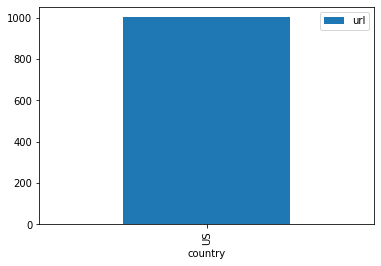

In [97]:
#visualicemos la distribución de paises
df.groupby(['country']).count().reset_index().plot(x = 'country', y = 'url', kind = 'bar')
plt.show()

Todas las campañas de la tabla provienen de estados unidos.

## Distribución de tags:

In [100]:
# veamos la tabla
#df.groupby('tags').count()[['url']]

[]

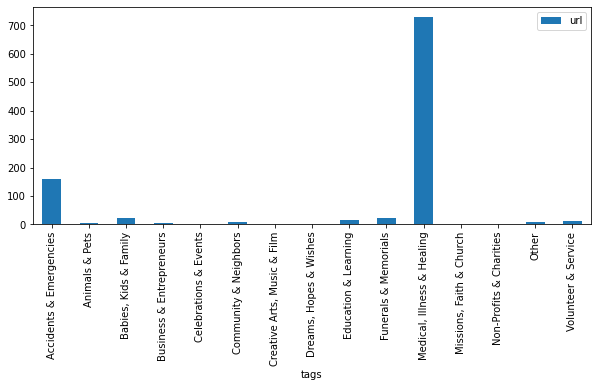

In [101]:
# visualicemos la distribución de tags
df.groupby('tags').count().reset_index().plot(x = 'tags', y = 'url', kind = 'bar', figsize = (10, 4))
plt.plot()

## Número de campañas 

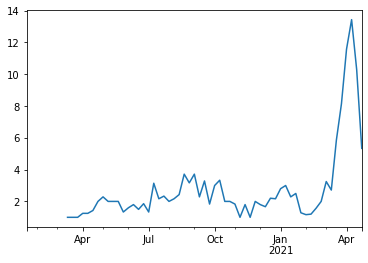

In [144]:
serie_diaria = pd.to_datetime(df['launch_date']).value_counts() # Creamos una serie de tiempo a partir

serie_diaria[serie_diaria.index > pd.to_datetime('2020-01-01')].resample('W').mean().plot()
plt.show()

## Distribución de dinero colectado y total:

### Limpieza de divisas

Antes que todo, verifiquemos que los datos estén completos:

In [116]:
# sub df de datos con valores nulos para la variable 'total_amount'
df[pd.isnull(df['total_amount'])]

,url,title,tags,current amount,total_amount,description,created,launch_date,country,donation_count,is_charity
47,https://www.gofundme.com/f/help-my-mom-to-surv...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,US,0,false


Vemos que es solo un dato, del que no tenemos más información, ignoraremos esta fila de nuestro análisis.

In [117]:
ndf = df[pd.isnull(df['total_amount']) == False]

Algo de lo que nos percatamos es que el dinero no se solicita en la misma divisa. Para solucionar esto, se identifican los signos de todas las divisas presentes en nuestros datos. 

Para este paso creamos una función que recibe una lista/arreglo/serie de cantidades de dinero expresadas en diferentes divisas y devuelve la lista de símbolos de cada una de estas divisas:

In [111]:
def lista_signos(dinero):
    signos = []
    for string in dinero:
        signo = ''
        string = str(string)
        for char in string:
            if char.isnumeric():
                break
            else:
                signo += char
        if signo == '':
            signo = 'no registra'
        signos.append(signo) 
    return signos

Ahora, identificamos los símbolos para las cantidades de dinero en las columnas: *current amount*, *total_amount*

In [115]:
#current amount
signos_current = lista_signos(ndf['current amount'])

#total_amount
signos_total = lista_signos(ndf['total_amount'])

#veamos cuáles signos se encuentra en cada caso
print(set(signos_current), set(signos_total))

{'£', '$', '€', 'kr', 'no registra', 'CHF'} {'£', '$', '€', 'kr', 'CHF'}


y graficamos:

In [ ]:
ndf.boxplot(column = 'total_amount', by = 'tags')
plt.plot()